<a href="https://colab.research.google.com/github/Ceciliaces/Examples_PINN_Handbook/blob/main/Oscilador_subamortiguado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PINN oscilador amortiguado**
Esta PINN tiene el proposito de aprender el comportamiento de un oscilador subamortiguado.

El desplazamiento $x(t)$ de una masa en el extremo de un resorte sobre el que actúan fuerzas de fricción es descrito por la siguiente ecuación:
\begin{equation}
    m\ddot{x} + b \dot{x} + kx = 0,
\end{equation}

donde $m$ es la masa, $b$ es el coeficiente de amortiguación y $k$ es la constante elástica del resorte. Si el coeficiente de amortiguamiento es igual a $2\sqrt{km}$ tendremos un amortiguamiento crítico en el que la masa no oscila y vuelve directamente a su posición de equilibrio, si es mayor que este valor tendremos un sobreamortiguamiento donde el sistema tampoco oscila pero vuelve más lentamente a su posición de equilibro que en el amortiguamiento crítico. Si $b<2\sqrt{km}$ entonces tenemos un sistema subamortiguado en el que el sistema oscila pero la amplitud de las oscilaciones disminuye exponencialmente. Nos enfocaremos en encontrar el desplazamiento en función del tiempo de este último tipo de amortiguamiento.

Este problema se puede resolver de manera analítica, al ser una ecuación diferencial ordinaria de coeficientes constantes su solución es:
\begin{equation}
    x(t)=e^{\frac{-b}{2m}t}\left[x_0\cos{(w't)}+\frac{v_0+\frac{bx_0}{2m}}{w'}\sin{(w't)}\right],
\end{equation}
donde $x_0$ y $v_0$ son la posición y velocidad iniciales, y $w'=\sqrt{\frac{k}{m}-\frac{b^2}{4m^2}}$ es la frecuencia angular de la oscilación. En este caso en especifico, consideraremos las siguientes condiciones iniciales:
$$x_0=1 \ m, \hspace{1cm} v_0 = -2 \ \frac{m}{s}.$$

Buscamos que la PINN simule el comportamiento del oscilador con el conocimiento que tenemos del sistema, es decir, con la euación diferencial y las condiciones iniciales, por lo que se entrenara utilizando la siguiente función de pérdida:
\begin{equation}
    \mathcal{L}(t;\mathbf{p})= \frac{\omega_f}{N_f}\sum_{i=1}^{N_f} \left((m\frac{d^2}{dt^2}+b\frac{d}{dt}+k)x_{\mathcal{N}}(t_i;\mathbf{p})\right)^2 +\omega_i\left[(x_{\mathcal{N}}(t=0;\mathbf{p})-x_0)^2  +\left(\frac{d}{dt}x_{\mathcal{N}}(t=0;\mathbf{p})-v_0\right)^2 \right],
\end{equation}
en este caso utilizamos los valores $m=3 \ \mathrm{kg}$, $b=2 \ \mathrm{\frac{kg}{s}}$, $ k = 10 \ \mathrm{\frac{kg}{s^2}}$ y buscamos que la PINN aprenda a simular la solución en el dominio $t \in [0,10]$. La solución analítica se utilizará como referencia del aprendizaje de la PINN. A continuación se encuentra el código para entrenar a la PINN.

In [1]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Coeficientes del sistema
m=3 ; b=2; k=10

# Geometría del problema. Parametros para el dominio temporal
t_min = 0 ; t_max = 10 # Tiempo total. Inicia en 0

# Se define el dominio temporal
t = tf.random.uniform((100, 1), t_min, t_max)

# Se añade t=0 para las condiciones iniciales
t_ic = tf.zeros((1,1))
t = tf.concat([t, t_ic], axis=0)

In [4]:
# Se define el modelo de la red neuronal
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x) # Esto es el output x

In [5]:
# Se define la pérdida de la ecuación diferencial
def EDO_perdida(model, t):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([t])
            x = model(t)
        x_t = tape1.gradient(x, t)
    x_tt = tape2.gradient(x_t, t)

    # Ecuación del oscilador amortiguado
    Perdida = m*x_tt + b*x_t + k*x

    # Se define Loss ODE (el término de la ecuación diferencial en la función de pérdida) como un MSE
    loss_pde = tf.reduce_mean(tf.square(Perdida))

    return loss_pde

# Se define la pérdida de las condiciones iniciales
def IC_perdida(model, t):
    x_t_0 = model(t_ic)

    # Condición inicial de la posición
    ic_loss_1 = tf.square(x_t_0 - 1)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([t])
        x = model(t)
    x_t = tape.gradient(x, t)

    # Condición inicial de la velocidad
    mask_ic = tf.abs(t) < 1e-5
    ic_loss_2 = tf.reduce_mean(tf.where(mask_ic, tf.square(x_t + 2), 0.0))

    return ic_loss_1 + ic_loss_2

# Función de pérdida
def Funcion_Perdida(model, t):
    # Loss EDP
    loss_pde = EDO_perdida(model, t)

    # Loss condición inicial
    loss_ic = IC_perdida(model, t)

    # Pesos de cada término en la función de pérdida
    lambda_pde = 0.5; lambda_ic = 1.0

    # Pérdida total
    total_loss = lambda_pde * loss_pde + lambda_ic * loss_ic
    return total_loss

In [6]:
# Optimizadores: Adam
adam = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# Paso de entrenamiento con ADAM
@tf.function
def train_step(model, t):
    with tf.GradientTape(persistent=True) as tape:
        loss = Funcion_Perdida(model, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    adam.apply_gradients(zip(gradients, model.trainable_variables))

    # Manualmente borramos el tape para salvar memoria
    del tape
    return loss

In [7]:
# Ciclo de entrenamiento
def train(model, t, epochs=1000):
    Total_loss=[] ; Loss_EDO=[] ; CI_loss=[]

    # Entrenamiento
    for epoch in range(epochs):
        loss = train_step(model, t)
        Total_loss.append(loss.numpy())

        # Loss EDP
        loss_edo = EDO_perdida(model, t)
        Loss_EDO.append(loss_edo.numpy())

        # Loss condición inicial
        loss_ic = IC_perdida(model, t)
        CI_loss.append(loss_ic.numpy())

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}, EDO Loss: {loss_edo.numpy()}, Initial Cond. Loss: {loss_ic.numpy()}')

    # Compute final losses
    final_loss = Funcion_Perdida(model, t)
    final_loss_edo = EDO_perdida(model, t)
    final_loss_ic = IC_perdida(model, t)

    print(f'Final Loss: {final_loss.numpy()}, EDO Loss: {final_loss_edo.numpy()}, Initial Cond. Loss: {final_loss_ic.numpy()}')

    return Loss_EDO, CI_loss, Total_loss

In [8]:
# Se entrena a la red
model = PINN()
Loss_EDO, CI_loss, Total_loss=train(model, t, epochs=15000)

Epoch 0, Loss: [[1.9264581]], EDO Loss: 1.475359320640564, Initial Cond. Loss: [[1.0529369]]
Epoch 1000, Loss: [[0.40753302]], EDO Loss: 0.39634808897972107, Initial Cond. Loss: [[0.20910741]]
Epoch 2000, Loss: [[0.3263883]], EDO Loss: 0.3962830901145935, Initial Cond. Loss: [[0.12820387]]
Epoch 3000, Loss: [[0.28100064]], EDO Loss: 0.3551773130893707, Initial Cond. Loss: [[0.10336147]]
Epoch 4000, Loss: [[0.21384478]], EDO Loss: 0.28468531370162964, Initial Cond. Loss: [[0.07139292]]
Epoch 5000, Loss: [[0.1263009]], EDO Loss: 0.18468596041202545, Initial Cond. Loss: [[0.03391615]]
Epoch 6000, Loss: [[0.09228338]], EDO Loss: 0.14083334803581238, Initial Cond. Loss: [[0.02184175]]
Epoch 7000, Loss: [[0.05222873]], EDO Loss: 0.07509716600179672, Initial Cond. Loss: [[0.01461866]]
Epoch 8000, Loss: [[0.03261943]], EDO Loss: 0.04922471195459366, Initial Cond. Loss: [[0.00800079]]
Epoch 9000, Loss: [[0.0282864]], EDO Loss: 0.04489950090646744, Initial Cond. Loss: [[0.00586246]]
Epoch 10000,

In [9]:
for i in range(0,len(CI_loss)):
  CI_loss[i]=CI_loss[i][0][0]

for i in range(0,len(Total_loss)):
  Total_loss[i]=Total_loss[i][0][0]

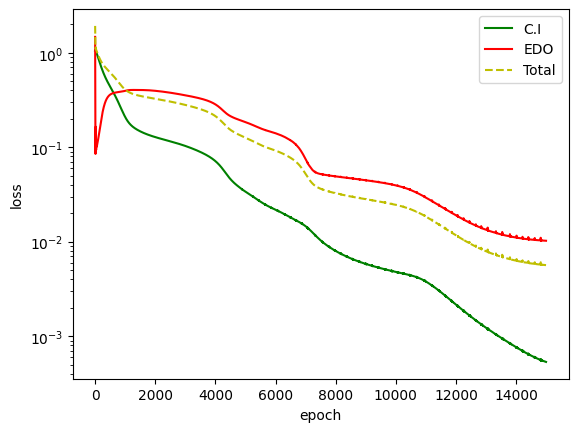

In [10]:
# Figura de los términos de la función error
fig = plt.figure(1)
plt.plot(CI_loss,'g',label='C.I')
plt.plot(Loss_EDO,'r',label='EDO')
plt.plot(Total_loss,'--y',label='Total')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.savefig('loss function.png',dpi=400)
plt.show()

In [11]:
# Obtener la predicción del modelo para t=0
print(model(tf.constant([0.0], shape=(1,1))).numpy().flatten()[0])

0.9983529


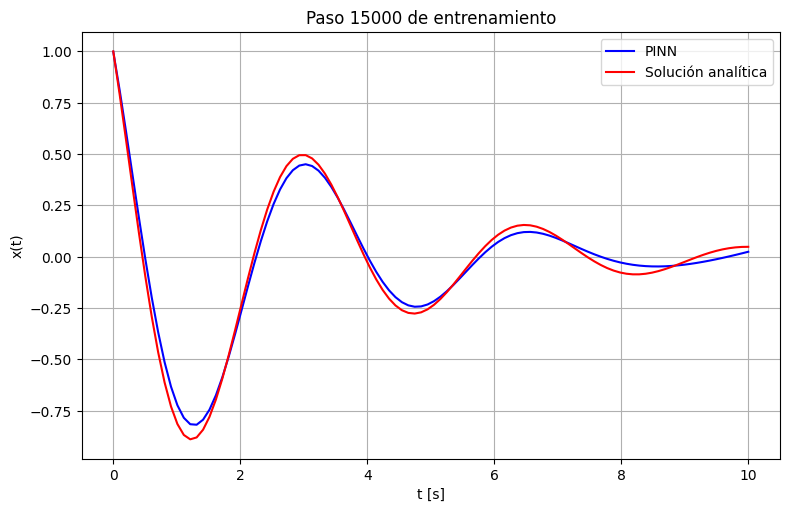

In [12]:
# Se crea un arreglo de puntos desde 0 hasta t_max
t_values = np.linspace(0, 10, 100)  # 100 time points from 0 to t_max

# Se define la solución analítica pr los valores de t
w = np.sqrt(k/m - b**2/(4*m**2))
x_real = np.exp(-b*t_values/(2*m))*(np.cos(w*t_values)+(-2+b/(2*m))/w * np.sin(w*t_values))

# Se realiza la predicción
x_predictions = []
for i in t_values:
  x_predictions.append(model(tf.ones((1,1))*i).numpy().flatten())

# Se grafica la predicción junto al sismograma
plt.figure(figsize=(8, 5))
plt.plot(t_values, x_predictions, "b-", label='PINN')
plt.plot(t_values, x_real,"r-", label='Solución analítica')
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.tight_layout()
plt.title("Paso 15000 de entrenamiento")
plt.legend()
plt.grid(True)
plt.show()